# 03 — Listing-Level Demand Forecasting (Spark MLlib / Big-Data Strategy)

This notebook trains **listing-level demand models** directly in Spark using the engineered dataset from Notebook 02.

**Data source (single source of truth):**
- `data/processed/listing_features.parquet` (includes `elasticity_slope` already added in Notebook 02)

**Goal:** predict **booking demand** (`n_bookings`) using listing + pricing + market context features (including `elasticity_slope`).

**Approach (Spark-native):**
- Load Parquet into a Spark DataFrame (no pandas conversion)
- Build a Spark MLlib pipeline: type cleaning → imputation → vector assembly → model
- Train and evaluate multiple regressors (baseline + tree models)
- Train and evaluate PyTorch Model
- Train and evaluate TensorFlow Keras model
- Compare the best model and feature importances (where supported)

**Outputs**
- `outputs/spark_model_results.csv`
- `outputs/spark_feature_importance.csv` (tree models)
- `models/spark_MLlib_model/` (Spark MLlib pipeline model)
- `models/airbnb_keras_model.keras`
- `models/airbnb_pytorch_model.pth`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd

# Locate project root (folder containing 'src')
project_root = Path.cwd()
for p in [project_root] + list(project_root.parents):
    if (p / 'src').exists():
        project_root = p
        break
if not (project_root / 'src').exists():
    raise FileNotFoundError("Could not find 'src' directory.")

# Windows Spark/Hadoop helpers (assumes hadoop binaries already exist from Notebook 01)
hadoop_home = project_root / 'hadoop'
bin_dir = hadoop_home / 'bin'
os.environ['HADOOP_HOME'] = str(hadoop_home)
os.environ['hadoop.home.dir'] = str(hadoop_home)
os.environ['PATH'] = str(bin_dir) + os.pathsep + os.environ.get('PATH', '')

sys.path.insert(0, str(project_root))

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.storagelevel import StorageLevel

spark = (
    SparkSession.builder
    .appName('airbnb-demand-forecasting-sparkml')
    .master('local[*]')
    # Stability / memory headroom for ML on Windows
    .config('spark.driver.memory', '4g')
    .config('spark.sql.shuffle.partitions', '64')
    .config('spark.default.parallelism', '64')
    .getOrCreate()
 )

# Keep Spark execution stable on Windows
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")

print('Spark version:', spark.version)
np.random.seed(42)

Spark version: 3.5.0


In [3]:
# Persist datasets (Spark writes)
out_processed = project_root / 'data' / 'processed'
out_processed.mkdir(parents=True, exist_ok=True)
outputs_dir = project_root / 'outputs'
outputs_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Verify listing features file exists
listing_features_file = out_processed / 'listing_features.parquet'
print(f"Listing features path: data/processed/listing_features.parquet")

if listing_features_file.exists():
    print(f"File exists: {listing_features_file.exists()}")
else:
    print("File not found. Run Notebook 02 to generate listing_features.parquet")

Listing features path: data/processed/listing_features.parquet
File exists: True


In [5]:
# Load listing-level engineered features (Spark-only)
listing_features_path = str(out_processed / 'listing_features.parquet')
if not Path(listing_features_path).exists():
    raise FileNotFoundError(f"Missing {listing_features_path}. Run Notebook 02 first.")

df = (
    spark.read.option('mergeSchema', 'true')
    .parquet(listing_features_path)
    .persist(StorageLevel.MEMORY_AND_DISK)
 )

print(f"Loaded listing_features.parquet with {len(df.columns)} columns")
df.printSchema()

# Quick sanity checks
required_cols = ['n_bookings', 'elasticity_slope']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in parquet: {missing}")

df.select(required_cols).summary().show(truncate=False)

Loaded listing_features.parquet with 49 columns
root
 |-- city: string (nullable = true)
 |-- weekend: integer (nullable = true)
 |-- listing_price: double (nullable = true)
 |-- room_shared: integer (nullable = true)
 |-- room_private: integer (nullable = true)
 |-- person_capacity: double (nullable = true)
 |-- host_is_superhost: integer (nullable = true)
 |-- multi: integer (nullable = true)
 |-- biz: integer (nullable = true)
 |-- cleanliness_rating: double (nullable = true)
 |-- guest_satisfaction_overall: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- city_center_dist: double (nullable = true)
 |-- metro_dist: double (nullable = true)
 |-- n_bookings: integer (nullable = true)
 |-- cat_room_type_entire_home_apt: integer (nullable = true)
 |-- cat_room_type_private_room: integer (nullable = true)
 |-- cat_room_type_shared_room: integer (nullable = true)
 |-- cat_city_amsterdam: integer (nullable = true)
 |-- cat_city_athens: integer (nullable = true)
 |-- ca

In [6]:
# Basic cleaning: ensure label is double, and keep only usable feature columns
from pyspark.sql.types import (
    StringType, BooleanType, NumericType
 )

target_col = 'n_bookings'
label_col = 'label'

df2 = df.withColumn(label_col, F.col(target_col).cast('double'))

# Cast booleans to ints (Spark ML prefers numeric features)
for field in df2.schema.fields:
    if isinstance(field.dataType, BooleanType):
        df2 = df2.withColumn(field.name, F.col(field.name).cast('int'))

# Drop redundant columns if they exist
_redundant = ['city', 'weekend', 'room_shared', 'room_private', 'log_bookings']
_to_drop = [c for c in _redundant if c in df2.columns]
if _to_drop:
    df2 = df2.drop(*_to_drop)
    print(f"Dropped columns: {_to_drop}")

# Drop rows with null label
df2 = df2.filter(F.col(label_col).isNotNull())

print('Rows after label cleaning (lazy):')
df2.select(F.count('*').alias('rows')).show()

Dropped columns: ['city', 'weekend', 'room_shared', 'room_private', 'log_bookings']
Rows after label cleaning (lazy):
+-----+
| rows|
+-----+
|51707|
+-----+



In [7]:
# Build a Spark ML pipeline (handles numeric + string cols)
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    Imputer, StringIndexer, OneHotEncoder, VectorAssembler
 )
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Columns to exclude from features
exclude_cols = {target_col, label_col}
for maybe_id in ['id', 'listing_id']:
    if maybe_id in df2.columns:
        exclude_cols.add(maybe_id)

string_cols = []
numeric_cols = []
for field in df2.schema.fields:
    if field.name in exclude_cols:
        continue
    if isinstance(field.dataType, StringType):
        string_cols.append(field.name)
    elif isinstance(field.dataType, NumericType):
        numeric_cols.append(field.name)

print(f"String feature cols: {len(string_cols)}")
print(f"Numeric feature cols: {len(numeric_cols)}")
if len(string_cols) > 0:
    print('Example string cols:', string_cols[:10])
print('Example numeric cols:', numeric_cols[:10])

# Split
train_df, test_df = df2.randomSplit([0.8, 0.2], seed=42)
train_df = train_df.persist(StorageLevel.MEMORY_AND_DISK)
test_df = test_df.persist(StorageLevel.MEMORY_AND_DISK)

# Stages: index + encode for strings, impute for numerics, assemble features
stages_common = []

indexed_cols = [f"{c}__idx" for c in string_cols]
ohe_cols = [f"{c}__ohe" for c in string_cols]
for c, idx in zip(string_cols, indexed_cols):
    stages_common.append(StringIndexer(inputCol=c, outputCol=idx, handleInvalid='keep'))
if string_cols:
    stages_common.append(OneHotEncoder(inputCols=indexed_cols, outputCols=ohe_cols, handleInvalid='keep'))

imputed_numeric_cols = [f"{c}__imp" for c in numeric_cols]
if numeric_cols:
    stages_common.append(Imputer(inputCols=numeric_cols, outputCols=imputed_numeric_cols, strategy='median'))

feature_cols = []
feature_cols.extend(imputed_numeric_cols)
feature_cols.extend(ohe_cols)

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features', handleInvalid='keep')
stages_common.append(assembler)

# Evaluators
evaluator_rmse = RegressionEvaluator(labelCol=label_col, predictionCol='prediction', metricName='rmse')
evaluator_mae = RegressionEvaluator(labelCol=label_col, predictionCol='prediction', metricName='mae')
evaluator_r2 = RegressionEvaluator(labelCol=label_col, predictionCol='prediction', metricName='r2')

print('Pipeline stages ready.')

String feature cols: 1
Numeric feature cols: 42
Example string cols: ['capacity_bin']
Example numeric cols: ['listing_price', 'person_capacity', 'host_is_superhost', 'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'city_center_dist', 'metro_dist']
Pipeline stages ready.


In [21]:
# Create a pandas DataFrame with model metrics and (where available) feature importances
models_summary_info = pd.DataFrame(columns=[
    'model', 'rmse', 'mae', 'r2'
])
models_summary_info

,model,rmse,mae,r2


In [22]:
# Train and compare Spark MLlib models (safe defaults for local Windows)
def fit_eval(model_name: str, regressor):
    pipeline = Pipeline(stages=stages_common + [regressor])
    model = pipeline.fit(train_df)
    preds = model.transform(test_df)
    rmse = evaluator_rmse.evaluate(preds)
    mae = evaluator_mae.evaluate(preds)
    r2 = evaluator_r2.evaluate(preds)
    return model, {'model': model_name, 'rmse': float(rmse), 'mae': float(mae), 'r2': float(r2)}

# Start with lighter models; scale up once stable
candidates = [
    ('LinearRegression', LinearRegression(featuresCol='features', labelCol=label_col, regParam=0.0, elasticNetParam=0.0, maxIter=200)),
    ('GBTRegressor', GBTRegressor(featuresCol='features', labelCol=label_col, maxIter=200, maxDepth=5, stepSize=0.1, subsamplingRate=0.8, seed=42)),
    # RandomForest can be heavier on some Windows setups; keep it last and modest
    ('RandomForest', RandomForestRegressor(featuresCol='features', labelCol=label_col, numTrees=200, maxDepth=8, maxBins=64, subsamplingRate=0.8, featureSubsetStrategy='sqrt', seed=42)),
 ]

results = []
trained = {}
for name, reg in candidates:
    print(f"Training {name}...")
    m, r = fit_eval(name, reg)
    trained[name] = m
    results.append(r)
    print(f"  RMSE={r['rmse']:.4f} | MAE={r['mae']:.4f} | R2={r['r2']:.4f}")

results_sorted = sorted(results, key=lambda x: x['rmse'])
print('')
print('Model comparison (sorted by RMSE):')
for r in results_sorted:
    print(f"- {r['model']}: RMSE={r['rmse']:.4f} | MAE={r['mae']:.4f} | R2={r['r2']:.4f}")
    # add them to the summary dataframe
    models_summary_info = pd.concat([models_summary_info, pd.DataFrame([r])], ignore_index=True)

results_sorted

Training LinearRegression...
  RMSE=3.8791 | MAE=2.8514 | R2=0.8146
Training GBTRegressor...
  RMSE=3.4568 | MAE=2.4125 | R2=0.8528
Training RandomForest...
  RMSE=3.6937 | MAE=2.6055 | R2=0.8319

Model comparison (sorted by RMSE):
- GBTRegressor: RMSE=3.4568 | MAE=2.4125 | R2=0.8528
- RandomForest: RMSE=3.6937 | MAE=2.6055 | R2=0.8319
- LinearRegression: RMSE=3.8791 | MAE=2.8514 | R2=0.8146


[{'model': 'GBTRegressor',
  'rmse': 3.456825912794064,
  'mae': 2.412482067911296,
  'r2': 0.8527853156662928},
 {'model': 'RandomForest',
  'rmse': 3.6937236960813618,
  'mae': 2.6055212339198435,
  'r2': 0.8319165609116553},
 {'model': 'LinearRegression',
  'rmse': 3.879093894670855,
  'mae': 2.8513647631744345,
  'r2': 0.8146226377308425}]

In [10]:
# Save best model + export metrics + feature importance (driver-side, no Spark createDataFrame)
import csv

best_name = results_sorted[0]['model']
best_model = trained[best_name]
print(f"Best model by RMSE: {best_name}")

models_dir = project_root / 'models'
models_dir.mkdir(parents=True, exist_ok=True)
best_path = models_dir / 'spark_MLlib_model'
best_model.write().overwrite().save(str(best_path))
print(f"Saved Spark PipelineModel to models\spark_MLlib_model")

# Save metrics (driver-side CSV)
outputs_dir = project_root / 'outputs'
outputs_dir.mkdir(parents=True, exist_ok=True)
metrics_path = outputs_dir / 'spark_model_results.csv'
with open(metrics_path, 'w', newline='', encoding='utf-8') as f:
    w = csv.DictWriter(f, fieldnames=['model', 'rmse', 'mae', 'r2'])
    w.writeheader()
    for r in results_sorted:
        w.writerow(r)
print(f"Saved metrics to outputs\spark_model_results.csv")

# Feature importance (only for tree models)
from pyspark.ml.regression import RandomForestRegressionModel, GBTRegressionModel

assembler_stage = [s for s in best_model.stages if s.__class__.__name__ == 'VectorAssembler'][0]
assembled_inputs = assembler_stage.getInputCols()
last_stage = best_model.stages[-1]

if isinstance(last_stage, (RandomForestRegressionModel, GBTRegressionModel)):
    fi = last_stage.featureImportances
    rows = [(assembled_inputs[i], float(fi[i])) for i in range(len(assembled_inputs))]
    rows = sorted(rows, key=lambda t: t[1], reverse=True)
    fi_path = outputs_dir / 'spark_feature_importance.csv'
    with open(fi_path, 'w', newline='', encoding='utf-8') as f:
        w = csv.writer(f)
        w.writerow(['feature', 'importance'])
        w.writerows(rows)
    print(f"Saved feature importances to: outputs\spark_feature_importance.csv")
    print('\nTop 25 features:')
    for feat, imp in rows[:25]:
        print(f"- {feat}: {imp:.6f}")
else:
    print('Best model does not provide feature importances (expected for LinearRegression).')

Best model by RMSE: GBTRegressor
Saved Spark PipelineModel to models\spark_MLlib_model
Saved metrics to outputs\spark_model_results.csv
Saved feature importances to: outputs\spark_feature_importance.csv

Top 25 features:
- is_weekend__imp: 0.314163
- listing_price__imp: 0.171128
- cleanliness_rating__imp: 0.072619
- price_per_person__imp: 0.068501
- host_is_superhost__imp: 0.068423
- guest_satisfaction_overall__imp: 0.066666
- quality_score__imp: 0.027099
- metro_dist__imp: 0.025298
- price_x_satisfaction__imp: 0.024324
- price_per_bedroom__imp: 0.020182
- city_center_dist__imp: 0.018708
- price_per_dist_km__imp: 0.017066
- price_vs_segment_median__imp: 0.015436
- person_capacity__imp: 0.013722
- price_vs_segment_avg__imp: 0.011956
- elasticity_slope__imp: 0.009484
- segment_price_std__imp: 0.008798
- relative_price_volatility__imp: 0.006919
- bedrooms__imp: 0.005777
- segment_avg_price__imp: 0.004879
- segment_listing_count__imp: 0.004548
- segment_price_spread__imp: 0.004328
- multi_

## Deep Learning Methods

### PyTorch

In [27]:
"""
Production PyTorch Training with PySpark - Big Data Ready
"""

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Force CPU
device = torch.device('cpu')
print(f"Using device: {device}\n")

# ============================================================================
# 1. ROBUST MODEL (no BatchNorm to avoid single-sample batch issues)
# ============================================================================
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
        )
    
    def forward(self, x):
        return self.network(x)

# ============================================================================
# 2. TRAINING FUNCTION - HANDLES BIG DATA + ROBUST TO DATA ISSUES
# ============================================================================
def train_pytorch_on_pyspark(train_df, test_df, feature_cols, target_col,
                             max_epochs=200, patience=15, batch_size=512,
                             num_chunks=5, target_is_log=False):
    """
    Trains PyTorch MLP on PySpark DataFrames with chunked processing.
    
    Args:
        target_is_log: Set True if target is already log-transformed
    """
    
    print(f"Training samples: {train_df.count():,}")
    print(f"Validation samples: {test_df.count():,}")
    print(f"Features: {len(feature_cols)}\n")
    
    # Convert validation set
    print("Converting validation data...")
    test_pd = test_df.toPandas()
    
    # Handle missing values
    test_pd = test_pd.fillna(0)
    
    X_val = torch.from_numpy(test_pd[feature_cols].values.astype(np.float32))
    y_val_raw = test_pd[target_col].values.astype(np.float32)
    
    # Apply log transform if needed
    if not target_is_log:
        y_val_raw = np.log1p(y_val_raw)  # log(1 + x) to handle zeros
        print("Applied log1p transform to target")
    
    y_val = torch.from_numpy(y_val_raw).view(-1, 1)
    
    print(f"Validation target range: [{y_val.min():.2f}, {y_val.max():.2f}]")
    
    # Initialize model
    num_features = len(feature_cols)
    model = MLPRegressor(num_features).to(device)
    optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                  patience=5)
    loss_fn = nn.MSELoss()
    
    best_rmse = float('inf')
    best_state = None
    patience_counter = 0
    
    print(f"\n{'='*70}")
    print("Starting training...")
    print(f"{'='*70}\n")
    
    # Training loop
    for epoch in range(max_epochs):
        model.train()
        total_loss = 0.0
        num_samples = 0
        
        # Split into chunks
        chunk_weights = [1.0 / num_chunks] * num_chunks
        train_chunks = train_df.randomSplit(chunk_weights, seed=42 + epoch)
        
        # Process each chunk
        for chunk_idx, chunk_df in enumerate(train_chunks):
            chunk_pd = chunk_df.toPandas()
            
            if len(chunk_pd) < 2:  # Skip tiny chunks
                continue
            
            # Handle missing values
            chunk_pd = chunk_pd.fillna(0)
            
            # Prepare data
            X_chunk = torch.from_numpy(chunk_pd[feature_cols].values.astype(np.float32))
            y_chunk_raw = chunk_pd[target_col].values.astype(np.float32)
            
            # Apply log transform if needed
            if not target_is_log:
                y_chunk_raw = np.log1p(y_chunk_raw)
            
            y_chunk = torch.from_numpy(y_chunk_raw).view(-1, 1)
            
            # Create DataLoader (drop_last=True avoids single-sample batches)
            chunk_loader = DataLoader(
                TensorDataset(X_chunk, y_chunk),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True  # Critical: avoids BatchNorm issues
            )
            
            # Train on chunk
            for xb, yb in chunk_loader:
                optimizer.zero_grad()
                pred = model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                
                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                total_loss += loss.item() * len(xb)
                num_samples += len(xb)
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = loss_fn(val_pred, y_val).item()
            
             # Calculate RMSE on ORIGINAL scale (inverse transform)
            pred_original = torch.expm1(val_pred).clamp(min=0)
            y_val_original = torch.expm1(y_val).clamp(min=0)
            
            mse_val = torch.mean((pred_original - y_val_original) ** 2).item()
            val_rmse = np.sqrt(mse_val)

            # Also track MAE
            val_mae = torch.mean(torch.abs(pred_original - y_val_original)).item()
            
            # Calculate R2
            y_var = torch.var(y_val_original).item()
            val_r2 = 1 - (mse_val / y_var) if y_var > 0 else 0.0
        
        scheduler.step(val_loss)
        
        avg_train_loss = total_loss / num_samples if num_samples > 0 else 0
        
        # Print every 5 epochs or when improving
        if epoch % 5 == 0 or val_rmse < best_rmse:
            print(f"Epoch {epoch+1:3d}/{max_epochs} | "
                  f"Train MSE: {avg_train_loss:.4f} | "
                  f"Val RMSE: {val_rmse:.2f} | "
                  f"Val MAE: {val_mae:.2f} | "
                  f"Val R2: {val_r2:.4f}")
        
        # Early stopping
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break
    
    # Restore best model
    if best_state:
        model.load_state_dict(best_state)
    
    print(f"\n{'='*70}")
    print(f"TRAINING COMPLETE")
    print(f"Best Validation RMSE: {best_rmse:.2f} bookings")
    print(f"Best Validation MAE:  {val_mae:.2f} bookings")
    print(f"{'='*70}\n")

    metrics = {
        'model': 'PyTorch_MLP',
        'rmse': float(best_rmse),
        'mae': float(val_mae),
        'r2': float(val_r2)
    }
    
    return model, metrics

# ============================================================================
# 3. CONFIGURE AND RUN
# ============================================================================

feature_cols = [col for col in train_df.columns if col != target_col and col != label_col]

print(f"Target column: {target_col}")
print(f"Feature columns: {feature_cols[:5]}... ({len(feature_cols)} total)\n")

# Train model
model, metrics = train_pytorch_on_pyspark(
    train_df=train_df,
    test_df=test_df,
    feature_cols=feature_cols,
    target_col=target_col,
    max_epochs= 200,
    patience=15,
    batch_size=512,  # Larger batch = fewer single-sample issues
    num_chunks=5,    # Fewer chunks = larger partitions = more stable
    target_is_log=False
)

print(f"Final PyTorch Model RMSE: {metrics['rmse']:.2f} bookings")
print(f"Final PyTorch Model MAE: {metrics['mae']:.2f} bookings")
print(f"Final PyTorch Model R2: {metrics['r2']:.4f}")

# add metrics to models_summary_info
models_summary_info = pd.concat([models_summary_info, pd.DataFrame([metrics])], ignore_index=True)

# ============================================================================
# 4. SAVE MODEL (Production-ready)
# ============================================================================
torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': {
        'input_dim': len(feature_cols),
        'class_name': 'MLPRegressor'
    },
    'feature_cols': feature_cols,
    'target_col': target_col,
    'metrics': {
        'rmse': float(metrics['rmse']),
        'mae': float(metrics['mae']),
        'r2': float(metrics['r2'])
    },
    'hyperparameters': {
        'batch_size': 512,
        'max_epochs': 200,
        'learning_rate': 1e-3
    }
}, '../models/airbnb_pytorch_model.pth')
print("\nModel saved to 'models/airbnb_pytorch_model.pth'")

Using device: cpu

Target column: n_bookings
Feature columns: ['listing_price', 'person_capacity', 'host_is_superhost', 'multi', 'biz']... (43 total)

Training samples: 41,439
Validation samples: 10,268
Features: 43

Converting validation data...
Applied log1p transform to target
Validation target range: [0.69, 4.06]

Starting training...

Epoch   1/200 | Train MSE: 63.0656 | Val RMSE: 20.82 | Val MAE: 10.88 | Val R2: -4.3417
Epoch   3/200 | Train MSE: 0.6564 | Val RMSE: 12.28 | Val MAE: 9.40 | Val R2: -0.8589
Epoch   5/200 | Train MSE: 0.4554 | Val RMSE: 12.12 | Val MAE: 9.32 | Val R2: -0.8094
Epoch   6/200 | Train MSE: 0.3980 | Val RMSE: 12.02 | Val MAE: 9.20 | Val R2: -0.7798
Epoch   7/200 | Train MSE: 0.3820 | Val RMSE: 11.99 | Val MAE: 9.13 | Val R2: -0.7696
Epoch   8/200 | Train MSE: 0.3341 | Val RMSE: 11.79 | Val MAE: 8.95 | Val R2: -0.7112
Epoch   9/200 | Train MSE: 0.3156 | Val RMSE: 11.63 | Val MAE: 8.79 | Val R2: -0.6654
Epoch  10/200 | Train MSE: 0.2946 | Val RMSE: 11.61 | 

Calculating permutation importance...
  Processed 10/43 features
  Processed 20/43 features
  Processed 30/43 features
  Processed 40/43 features

Top 10 Features (Permutation Importance):
                  feature   importance
28   price_x_satisfaction  1816.147933
34   segment_median_price  1673.133089
0           listing_price  1585.927571
32  segment_listing_count   219.697771
33      segment_avg_price    36.247955
25      price_per_bedroom    24.837027
38   segment_price_spread    20.230608
35      segment_p90_price    11.498032
37      segment_price_std     2.907846
31             is_weekend     1.238257

Top 10 Features (Gradient Importance):
               feature    importance
31          is_weekend  9.877094e-06
2    host_is_superhost  5.034658e-06
5   cleanliness_rating  1.460339e-06
14     cat_city_athens  8.888741e-07
20      cat_city_paris  7.593637e-07
21       cat_city_rome  7.466262e-07
15  cat_city_barcelona  7.114902e-07
1      person_capacity  6.417039e-07
42    ela

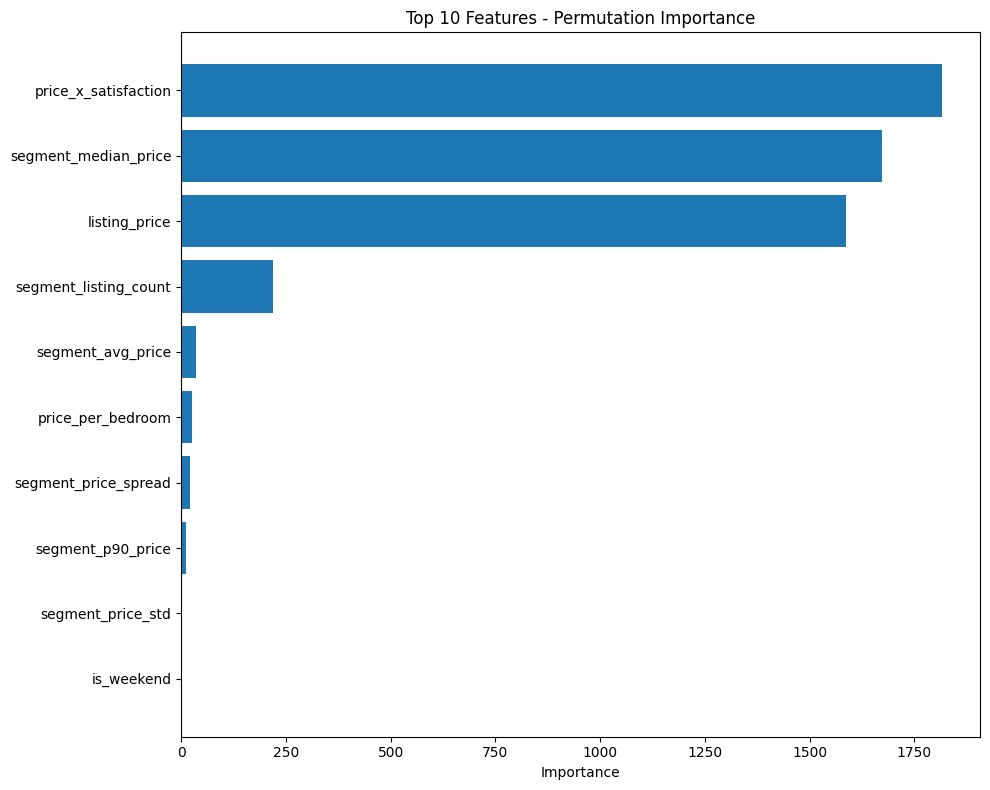

In [29]:
# PyTorch Model Feature Importance

"""
Feature Importance for PyTorch Neural Networks
"""

import torch
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ============================================================================
# METHOD 1: PERMUTATION IMPORTANCE (Most Reliable)
# ============================================================================
def get_permutation_importance(model, X_val, y_val, feature_cols, n_repeats=10):
    """
    Calculate feature importance by measuring performance drop
    when each feature is randomly shuffled.
    """
    model.eval()
    
    # Baseline performance with clipping
    with torch.no_grad():
        baseline_pred = model(X_val)
        baseline_pred = torch.clamp(baseline_pred, -10, 10)  # ADD THIS
        baseline_rmse = torch.sqrt(
            torch.mean((torch.expm1(baseline_pred) - torch.expm1(y_val)) ** 2)
        ).item()
    
    importances = []
    
    print("Calculating permutation importance...")
    for i, feature in enumerate(feature_cols):
        importance_scores = []
        
        for _ in range(n_repeats):
            # Create copy and shuffle feature i
            X_permuted = X_val.clone()
            shuffle_idx = torch.randperm(X_val.size(0))
            X_permuted[:, i] = X_permuted[shuffle_idx, i]
            
            # Calculate performance drop with clipping
            with torch.no_grad():
                perm_pred = model(X_permuted)
                perm_pred = torch.clamp(perm_pred, -10, 10)  # ADD THIS
                
                # Check for invalid predictions
                if torch.isnan(perm_pred).any() or torch.isinf(perm_pred).any():
                    importance_scores.append(0)  # Skip invalid
                    continue
                
                perm_rmse = torch.sqrt(
                    torch.mean((torch.expm1(perm_pred) - torch.expm1(y_val)) ** 2)
                ).item()
            
            # Importance = increase in error
            importance = perm_rmse - baseline_rmse
            
            # Handle overflow/invalid values
            if np.isnan(importance) or np.isinf(importance):
                importance_scores.append(0)
            else:
                importance_scores.append(max(0, importance))  # Only positive importance
        
        avg_importance = np.mean(importance_scores)
        importances.append(avg_importance)
        
        if (i + 1) % 10 == 0:
            print(f"  Processed {i+1}/{len(feature_cols)} features")
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    return importance_df

# ============================================================================
# METHOD 2: GRADIENT-BASED IMPORTANCE (Fast Alternative)
# ============================================================================
def get_gradient_importance(model, X_val, y_val, feature_cols):
    """
    Calculate feature importance based on gradients.
    Measures how much each feature affects the loss.
    """
    model.eval()
    
    # Enable gradient tracking for input
    X_val_grad = X_val.clone().requires_grad_(True)
    
    # Forward pass
    pred = model(X_val_grad)
    loss = torch.mean((pred - y_val) ** 2)
    
    # Backward pass to get gradients
    loss.backward()
    
    # Calculate importance as mean absolute gradient
    gradient_importance = torch.mean(torch.abs(X_val_grad.grad), dim=0).detach().numpy()
    
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': gradient_importance
    }).sort_values('importance', ascending=False)
    
    return importance_df

# ============================================================================
# METHOD 3: FIRST LAYER WEIGHTS (Approximation for Linear Relationships)
# ============================================================================
def get_weight_importance(model, feature_cols):
    """
    Analyze first layer weights as proxy for feature importance.
    Works best for relatively simple patterns.
    """
    # Get first layer weights
    first_layer = list(model.parameters())[0]  # First Linear layer weights
    weights = first_layer.detach().numpy()
    
    # Calculate mean absolute weight for each input feature
    weight_importance = np.mean(np.abs(weights), axis=0)
    
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': weight_importance
    }).sort_values('importance', ascending=False)
    
    return importance_df

# ============================================================================
# VISUALIZATION
# ============================================================================
def plot_feature_importance(importance_df, top_n=10, title="Feature Importance"):
    """
    Plot top N most important features.
    """
    top_features = importance_df.head(top_n)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# ============================================================================
# USAGE WITH PYTORCH MODEL
# ============================================================================

# Prepare validation data (from your test_df)
test_pd = test_df.toPandas().fillna(0)
X_val = torch.from_numpy(test_pd[feature_cols].values.astype(np.float32))
y_val = torch.from_numpy(np.log1p(test_pd[target_col].values.astype(np.float32))).view(-1, 1)

# Method 1: Permutation Importance (RECOMMENDED - most accurate)
perm_importance = get_permutation_importance(model, X_val, y_val, feature_cols, n_repeats=10)
print("\nTop 10 Features (Permutation Importance):")
print(perm_importance.head(10))

# Method 2: Gradient Importance (fast, good approximation)
grad_importance = get_gradient_importance(model, X_val, y_val, feature_cols)
print("\nTop 10 Features (Gradient Importance):")
print(grad_importance.head(10))

# Method 3: Weight Analysis (quick but less accurate)
weight_importance = get_weight_importance(model, feature_cols)
print("\nTop 10 Features (Weight Analysis):")
print(weight_importance.head(10))

# Visualize
plot_feature_importance(perm_importance, top_n=10, 
                       title="Top 10 Features - Permutation Importance")


### TensorFlow Keras Neural Network

In [24]:
"""
Production TensorFlow/Keras Training with PySpark - Big Data Ready
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import warnings

# Suppress warnings for clean output
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

# Force CPU for compatibility
tf.config.set_visible_devices([], 'GPU')
print(f"Using device: CPU\n")
print(f"TensorFlow version: {tf.__version__}\n")

# ============================================================================
# 1. BUILD KERAS MODEL WITH GRADIENT CLIPPING
# ============================================================================
def build_mlp_regressor(input_dim):
    """
    Creates a robust MLP regression model with output constraints.
    """
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.2),
        layers.Dense(1)  # No activation for regression
    ])
    
    return model

# ============================================================================
# 2. TRAINING FUNCTION - STABLE FOR BIG DATA
# ============================================================================
def train_keras_on_pyspark(train_df, test_df, feature_cols, target_col,
                           max_epochs=200, patience=15, batch_size=512,
                           num_chunks=5, target_is_log=False):
    """
    Trains TensorFlow/Keras model on PySpark DataFrames with chunked processing.
    Includes stability improvements to prevent overflow and NaN issues.
    Returns model and metrics dictionary.
    """
    
    print(f"Training samples: {train_df.count():,}")
    print(f"Validation samples: {test_df.count():,}")
    print(f"Features: {len(feature_cols)}\n")
    
    # Convert validation set
    print("Converting validation data...")
    test_pd = test_df.toPandas()
    test_pd = test_pd.fillna(0)
    
    X_val = test_pd[feature_cols].values.astype(np.float32)
    y_val_raw = test_pd[target_col].values.astype(np.float32)
    
    # Apply log transform if needed
    if not target_is_log:
        y_val_raw = np.log1p(y_val_raw)
        print("Applied log1p transform to target")
    
    y_val = y_val_raw.reshape(-1, 1)
    
    print(f"Validation target range: [{y_val.min():.2f}, {y_val.max():.2f}]")
    
    # Initialize model
    num_features = len(feature_cols)
    model = build_mlp_regressor(num_features)
    
    # Compile with gradient clipping for stability
    optimizer = keras.optimizers.Adam(
        learning_rate=1e-3,
        clipnorm=1.0  # Clip gradients to prevent explosion
    )
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    
    print("\nModel Architecture:")
    model.summary()
    
    # Learning rate reduction tracking
    lr_patience = 0
    lr_wait = 5
    best_val_loss = float('inf')
    
    best_rmse = float('inf')
    best_mae = float('inf')
    best_r2 = -float('inf')
    best_weights = None
    patience_counter = 0
    
    print(f"\n{'='*70}")
    print("Starting training...")
    print(f"{'='*70}\n")
    
    # Training loop
    for epoch in range(max_epochs):
        epoch_losses = []
        num_samples = 0
        
        # Split into chunks
        chunk_weights = [1.0 / num_chunks] * num_chunks
        train_chunks = train_df.randomSplit(chunk_weights, seed=42 + epoch)
        
        # Process each chunk
        for chunk_idx, chunk_df in enumerate(train_chunks):
            chunk_pd = chunk_df.toPandas()
            
            if len(chunk_pd) < 2:
                continue
            
            chunk_pd = chunk_pd.fillna(0)
            
            # Prepare data
            X_chunk = chunk_pd[feature_cols].values.astype(np.float32)
            y_chunk_raw = chunk_pd[target_col].values.astype(np.float32)
            
            if not target_is_log:
                y_chunk_raw = np.log1p(y_chunk_raw)
            
            y_chunk = y_chunk_raw.reshape(-1, 1)
            
            # Train on chunk in batches
            num_samples_chunk = len(X_chunk)
            indices = np.arange(num_samples_chunk)
            np.random.shuffle(indices)
            
            for i in range(0, num_samples_chunk - batch_size, batch_size):
                batch_indices = indices[i:i + batch_size]
                X_batch = X_chunk[batch_indices]
                y_batch = y_chunk[batch_indices]
                
                # Train on batch
                loss = model.train_on_batch(X_batch, y_batch)
                epoch_losses.append(loss)
                num_samples += len(X_batch)
        
        # Validation phase
        val_pred = model.predict(X_val, verbose=0)
        
        # Clip predictions to prevent overflow (critical for stability)
        val_pred = np.clip(val_pred, -10, 10)  # Reasonable range for log-space
        
        val_loss = np.mean((val_pred - y_val) ** 2)
        
        # Calculate metrics on ORIGINAL scale with safe inverse transform
        with np.errstate(over='ignore', invalid='ignore'):  # Suppress overflow warnings
            pred_original = np.expm1(val_pred)
            y_val_original = np.expm1(y_val)
            
            # Clip to reasonable range
            pred_original = np.clip(pred_original, 0, 1e6)
            y_val_original = np.clip(y_val_original, 0, 1e6)
            
            val_rmse = np.sqrt(np.mean((pred_original - y_val_original) ** 2))
            val_mae = np.mean(np.abs(pred_original - y_val_original))
            
            # Calculate R²
            ss_res = np.sum((y_val_original - pred_original) ** 2)
            ss_tot = np.sum((y_val_original - np.mean(y_val_original)) ** 2)
            val_r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        
        # Learning rate reduction (manual implementation)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            lr_patience = 0
        else:
            lr_patience += 1
            if lr_patience >= lr_wait:
                old_lr = float(model.optimizer.learning_rate.numpy())
                new_lr = old_lr * 0.5
                model.optimizer.learning_rate.assign(new_lr)
                print(f"    → Reducing learning rate to {new_lr:.2e}")
                lr_patience = 0
        
        avg_train_loss = np.mean(epoch_losses) if epoch_losses else 0
        
        # Print every 5 epochs or when improving
        if epoch % 5 == 0 or val_rmse < best_rmse:
            print(f"Epoch {epoch+1:3d}/{max_epochs} | "
                  f"Train MSE: {avg_train_loss:.4f} | "
                  f"Val RMSE: {val_rmse:.2f} | "
                  f"Val MAE: {val_mae:.2f} | "
                  f"Val R²: {val_r2:.4f}")
        
        # Early stopping
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_mae = val_mae
            best_r2 = val_r2
            best_weights = model.get_weights()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break
    
    # Restore best weights
    if best_weights:
        model.set_weights(best_weights)
    
    print(f"\n{'='*70}")
    print(f"TRAINING COMPLETE")
    print(f"Best Validation RMSE: {best_rmse:.2f} bookings")
    print(f"Best Validation MAE:  {best_mae:.2f} bookings")
    print(f"Best Validation R²:   {best_r2:.4f}")
    print(f"{'='*70}\n")
    
    # Return metrics dictionary
    metrics = {
        'model': 'TensorFlow_Keras_MLP',
        'rmse': float(best_rmse),
        'mae': float(best_mae),
        'r2': float(best_r2)
    }
    
    return model, metrics

# ============================================================================
# 3. CONFIGURE AND RUN
# ============================================================================

feature_cols = [col for col in train_df.columns if col != target_col]
feature_cols = [col for col in train_df.columns if col != target_col and col != label_col]

print(f"Target column: {target_col}")
print(f"Feature columns: {feature_cols[:5]}... ({len(feature_cols)} total)\n")

# Train model
model, metrics = train_keras_on_pyspark(
    train_df=train_df,
    test_df=test_df,
    feature_cols=feature_cols,
    target_col=target_col,
    max_epochs=200,
    patience=15,
    batch_size=512,
    num_chunks=5,
    target_is_log=False
)

print(f"Final TensorFlow/Keras Model RMSE: {metrics['rmse']:.2f} bookings")

# ============================================================================
# 4. UPDATE SUMMARY DATAFRAME
# ============================================================================
models_summary_info = pd.concat([
    models_summary_info, 
    pd.DataFrame([metrics])
], ignore_index=True)

# ============================================================================
# 5. SAVE MODEL (Production-ready)
# ============================================================================
model.save('../models/airbnb_keras_model.keras')
print("\nModel saved to '../models/airbnb_keras_model.keras'")

# Save metadata
import json

metadata = {
    'model_type': 'TensorFlow_Keras_MLP',
    'framework_version': tf.__version__,
    'model_architecture': {
        'input_dim': len(feature_cols),
        'layers': [128, 64, 32, 1],
        'activation': 'relu',
        'dropout_rates': [0.3, 0.3, 0.2],
        'kernel_initializer': 'he_normal',  
        'output_activation': None  
    },
    'feature_cols': feature_cols,
    'target_col': target_col,
    'num_features': len(feature_cols),  
    'metrics': {
        'rmse': float(metrics['rmse']),
        'mae': float(metrics['mae']),
        'r2': float(metrics['r2'])
    },
    'hyperparameters': {
        'batch_size': 512,
        'max_epochs': 200,
        'patience': 15,  
        'num_chunks': 5,  
        'learning_rate': 1e-3,
        'optimizer': 'Adam',
        'clipnorm': 1.0,
        'lr_reduction_factor': 0.5,  
        'lr_reduction_patience': 5  
    },
    'preprocessing': {
        'target_transform': 'log1p',
        'missing_value_strategy': 'fill_zero',
        'prediction_clipping': [-10, 10],  
        'output_clipping': [0, 1e6]  
    },
    'training_info': {  
        'train_samples': train_df.count(),
        'val_samples': test_df.count(),
        'target_is_log': False,
        'device': 'CPU'
    }
}

with open('../models/airbnb_keras_model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("Metadata saved to '../models/airbnb_keras_model_metadata.json'")

Using device: CPU

TensorFlow version: 2.19.1

Target column: n_bookings
Feature columns: ['listing_price', 'person_capacity', 'host_is_superhost', 'multi', 'biz']... (43 total)

Training samples: 41,439
Validation samples: 10,268
Features: 43

Converting validation data...
Applied log1p transform to target
Validation target range: [0.69, 4.06]

Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,001 (62.50 KB)

 Trainable params: 16,001 (62.50 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...

Epoch   1/200 | Train MSE: 182751.2031 | Val RMSE: 2251.04 | Val MAE: 1032.38 | Val R²: -62424.3281
Epoch   2/200 | Train MSE: 43871.1797 | Val RMSE: 218.13 | Val MAE: 13.13 | Val R²: -585.1964
Epoch   3/200 | Train MSE: 25806.2363 | Val RMSE: 13.23 | Val MAE: 10.10 | Val R²: -1.1565
Epoch   4/200 | Train MSE: 18298.7793 | Val RMSE: 13.19 | Val MAE: 9.83 | Val R²: -1.1448
Epoch   5/200 | Train MSE: 14211.7471 | Val RMSE: 12.42 | Val MAE: 9.07 | Val R²: -0.9011
Epoch   6/200 | Train MSE: 11608.6182 | Val RMSE: 376.68 | Val MAE: 16.04 | Val R²: -1747.0392
Epoch   7/200 | Train MSE: 9812.1172 | Val RMSE: 11.75 | Val MAE: 8.44 | Val R²: -0.7007
Epoch   8/200 | Train MSE: 8498.6855 | Val RMSE: 11.48 | Val MAE: 8.24 | Val R²: -0.6232
Epoch  10/200 | Train MSE: 6695.7627 | Val RMSE: 11.32 | Val MAE: 8.21 | Val R²: -0.5795
Epoch  11/200 | Train MSE: 6057.2793 | Val RMSE: 11.61 | Val MAE: 8.48 | Val R²: -0.6603
Epoch  15/200 | Train MSE: 4393.0610 | Val RMSE: 10.95 | Val 

Calculating permutation importance...
  Processed 10/43 features
  Processed 20/43 features
  Processed 30/43 features
  Processed 40/43 features

Top 10 Features (Permutation Importance):
                  feature  importance
0           listing_price  852.863892
28   price_x_satisfaction  498.799713
34   segment_median_price  498.517487
32  segment_listing_count   32.814236
25      price_per_bedroom   26.089359
35      segment_p90_price    4.188895
38   segment_price_spread    2.006090
33      segment_avg_price    1.681856
37      segment_price_std    1.432160
31             is_weekend    0.814649

Top 10 Features (Gradient Importance):
              feature  importance
31         is_weekend    0.000009
2   host_is_superhost    0.000006
18    cat_city_lisbon    0.000005
14    cat_city_athens    0.000004
22    cat_city_vienna    0.000004
21      cat_city_rome    0.000002
16    cat_city_berlin    0.000002
42   elasticity_slope    0.000002
17  cat_city_budapest    0.000002
20     cat_ci

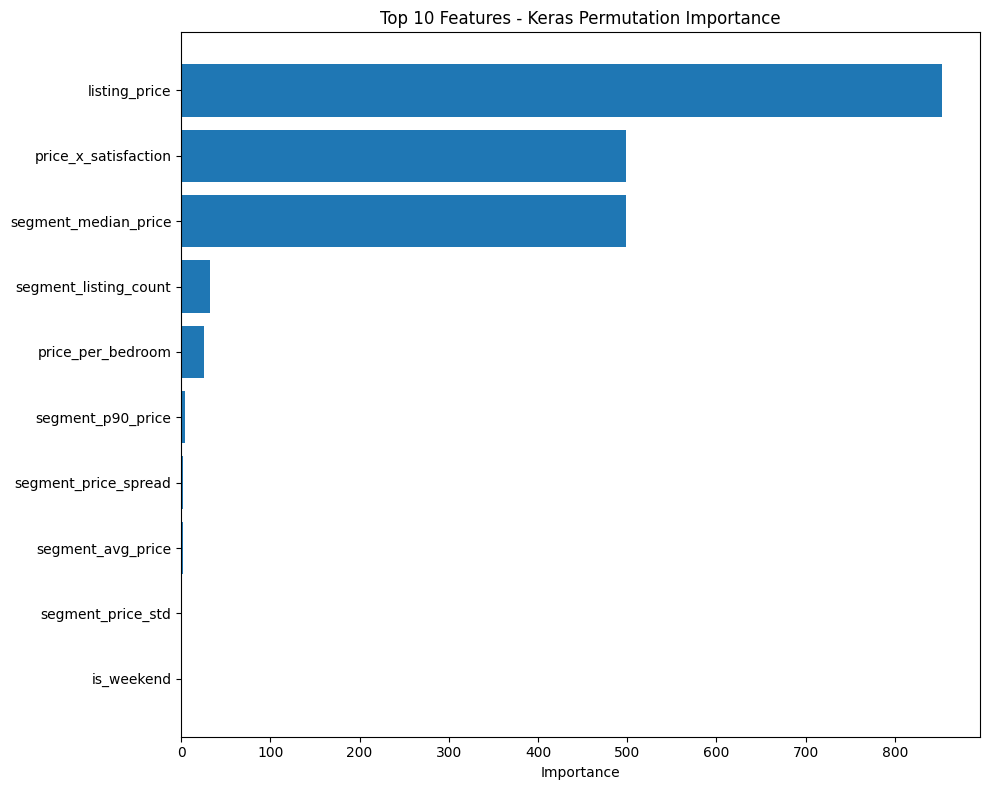

In [25]:
"""
Feature Importance for TensorFlow/Keras Neural Networks
"""

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================================
# METHOD 1: PERMUTATION IMPORTANCE (Most Reliable)
# ============================================================================
def get_permutation_importance_keras(model, X_val, y_val, feature_cols, n_repeats=10):
    """
    Calculate feature importance by measuring performance drop
    when each feature is randomly shuffled.
    """
    
    # Baseline performance
    baseline_pred = model.predict(X_val, verbose=0)
    baseline_pred = np.clip(baseline_pred, -10, 10)
    
    baseline_rmse = np.sqrt(
        np.mean((np.expm1(baseline_pred) - np.expm1(y_val)) ** 2)
    )
    
    importances = []
    
    print("Calculating permutation importance...")
    for i, feature in enumerate(feature_cols):
        importance_scores = []
        
        for _ in range(n_repeats):
            # Create copy and shuffle feature i
            X_permuted = X_val.copy()
            np.random.shuffle(X_permuted[:, i])
            
            # Calculate performance drop
            perm_pred = model.predict(X_permuted, verbose=0)
            perm_pred = np.clip(perm_pred, -10, 10)
            
            perm_rmse = np.sqrt(
                np.mean((np.expm1(perm_pred) - np.expm1(y_val)) ** 2)
            )
            
            # Importance = increase in error
            importance = perm_rmse - baseline_rmse
            importance_scores.append(importance)
        
        avg_importance = np.mean(importance_scores)
        importances.append(avg_importance)
        
        if (i + 1) % 10 == 0:
            print(f"  Processed {i+1}/{len(feature_cols)} features")
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    return importance_df

# ============================================================================
# METHOD 2: GRADIENT-BASED IMPORTANCE (Fast Alternative)
# ============================================================================
def get_gradient_importance_keras(model, X_val, y_val, feature_cols):
    """
    Calculate feature importance based on gradients.
    Measures how much each feature affects the loss.
    """
    
    # Convert to TensorFlow tensors
    X_val_tf = tf.Variable(X_val, dtype=tf.float32)
    y_val_tf = tf.constant(y_val, dtype=tf.float32)
    
    # Calculate gradients
    with tf.GradientTape() as tape:
        tape.watch(X_val_tf)
        pred = model(X_val_tf, training=False)
        loss = tf.reduce_mean((pred - y_val_tf) ** 2)
    
    # Get gradients with respect to input
    gradients = tape.gradient(loss, X_val_tf)
    
    # Calculate importance as mean absolute gradient
    gradient_importance = tf.reduce_mean(tf.abs(gradients), axis=0).numpy()
    
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': gradient_importance
    }).sort_values('importance', ascending=False)
    
    return importance_df

# ============================================================================
# METHOD 3: FIRST LAYER WEIGHTS (Approximation for Linear Relationships)
# ============================================================================
def get_weight_importance_keras(model, feature_cols):
    """
    Analyze first layer weights as proxy for feature importance.
    Works best for relatively simple patterns.
    """
    # Get first layer weights (skip Input layer, get first Dense layer)
    first_dense_layer = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            first_dense_layer = layer
            break
    
    if first_dense_layer is None:
        raise ValueError("No Dense layer found in model")
    
    # Get weights (weights[0] is the kernel, weights[1] is bias)
    weights = first_dense_layer.get_weights()[0]  # Shape: (input_dim, units)
    
    # Calculate mean absolute weight for each input feature
    weight_importance = np.mean(np.abs(weights), axis=1)
    
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': weight_importance
    }).sort_values('importance', ascending=False)
    
    return importance_df

# ============================================================================
# VISUALIZATION
# ============================================================================
def plot_feature_importance(importance_df, top_n=10, title="Feature Importance"):
    """
    Plot top N most important features.
    """
    top_features = importance_df.head(top_n)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# ============================================================================
# USAGE WITH KERAS MODEL
# ============================================================================

# Prepare validation data (from your test_df)
test_pd = test_df.toPandas().fillna(0)
X_val = test_pd[feature_cols].values.astype(np.float32)
y_val = np.log1p(test_pd[target_col].values.astype(np.float32)).reshape(-1, 1)

# Method 1: Permutation Importance (RECOMMENDED - most accurate)
perm_importance = get_permutation_importance_keras(model, X_val, y_val, feature_cols, n_repeats=10)
print("\nTop 10 Features (Permutation Importance):")
print(perm_importance.head(10))

# Method 2: Gradient Importance (fast, good approximation)
grad_importance = get_gradient_importance_keras(model, X_val, y_val, feature_cols)
print("\nTop 10 Features (Gradient Importance):")
print(grad_importance.head(10))

# Method 3: Weight Analysis (quick but less accurate)
weight_importance = get_weight_importance_keras(model, feature_cols)
print("\nTop 10 Features (Weight Analysis):")
print(weight_importance.head(10))

# Visualize
plot_feature_importance(perm_importance, top_n=10, 
                       title="Top 10 Features - Keras Permutation Importance")


## Model Summary

In [30]:
import json

# Show final summary

models_summary_info.sort_values('rmse', inplace=True, ascending=True, ignore_index=True)

print("Models summary:")
display(models_summary_info)

# Save as JSON
out_json = outputs_dir / 'model_results.json'
out_json.parent.mkdir(parents=True, exist_ok=True)
with open(out_json, 'w', encoding='utf-8') as f:
    json.dump(models_summary_info.to_dict(orient='records'), f, indent=2)

print(f"Saved model results to: outputs\model_results.json")


Models summary:


,model,rmse,mae,r2
0,GBTRegressor,3.456826,2.412482,0.852785
1,RandomForest,3.693724,2.605521,0.831917
2,LinearRegression,3.879094,2.851365,0.814623
3,PyTorch_MLP,5.813119,3.780191,0.572033
4,TensorFlow_Keras_MLP,6.986585,4.834354,0.398652


Saved model results to: outputs\model_results.json
